In [1]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/home/richard/pymc3_dev/')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sns
import pandas as pd

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.11.0


In [121]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass 
w2 = 1 - w1  # the other mode with 0.7 of the mass

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    #X = pm.Normal("X", mu=0, sigma=1, shape=n, testval=-1.0 * np.ones_like(mu1))
    
    llk = pm.Potential("llk", two_gaussians(X))
    trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.5, alpha=(0.5,0.5), NBfirstlayer=True)
    az_trace = az.from_pymc3(trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.011
Stage:   1 Beta: 0.030
Stage:   2 Beta: 0.067
Stage:   3 Beta: 0.147
Stage:   4 Beta: 0.324
Stage:   5 Beta: 0.673
Stage:   6 Beta: 1.000


0.007721599956555057


In [122]:
nf_evidence = trace.report.marginal_likelihood
print(f'NFMC calculated evidence: {nf_evidence[0]}')
az_summary = az.summary(az_trace)
print(az_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


NFMC calculated evidence: 0.007721599956555057
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.200  0.472  -0.685    0.606      0.011    0.008    1907.0  1907.0   
X[1] -0.197  0.471  -0.661    0.635      0.011    0.008    1992.0  1953.0   
X[2] -0.195  0.474  -0.693    0.606      0.011    0.008    1987.0  1862.0   
X[3] -0.191  0.471  -0.682    0.603      0.011    0.009    1941.0  1456.0   

      ess_bulk  ess_tail  r_hat  
X[0]    1818.0    1893.0    NaN  
X[1]    1964.0    1802.0    NaN  
X[2]    2009.0    1883.0    NaN  
X[3]    1858.0    1720.0    NaN  


<Figure size 720x480 with 0 Axes>

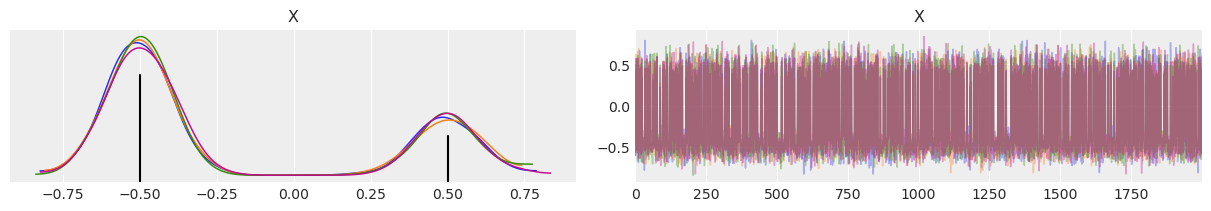

In [123]:
plt.figure()
ax = az.plot_trace(az_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

In [ ]:
plt.figure()
az.plot_posterior(az_trace, kind='hist')
plt.show()

Let's just check these results against those from SMC. 

In [116]:
with model:
    smc_trace = pm.sample_smc(2000)
    az_smc_trace = az.from_pymc3(smc_trace)

Initializing SMC sampler...
Sampling 2 chains in 0 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.011
Stage:   1 Beta: 0.029
Stage:   2 Beta: 0.065
Stage:   3 Beta: 0.143
Stage:   4 Beta: 0.313
Stage:   5 Beta: 0.653
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.011
Stage:   1 Beta: 0.029
Stage:   2 Beta: 0.064
Stage:   3 Beta: 0.139
Stage:   4 Beta: 0.298
Stage:   5 Beta: 0.648
Stage:   6 Beta: 1.000


In [117]:
smc_evidence = np.exp(smc_trace.report.log_marginal_likelihood)
print(f'SMC calculated evidence: {smc_evidence}')
az_smc_summary = az.summary(az_smc_trace)
print(az_smc_summary)

SMC calculated evidence: [0.00309185 0.00490881]
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.206  0.467  -0.678    0.616      0.007    0.005    4169.0  3962.0   
X[1] -0.206  0.463  -0.681    0.606      0.007    0.005    4013.0  4013.0   
X[2] -0.205  0.466  -0.690    0.607      0.007    0.005    4150.0  3715.0   
X[3] -0.207  0.468  -0.672    0.631      0.007    0.005    4091.0  4091.0   

      ess_bulk  ess_tail  r_hat  
X[0]    4154.0    3962.0    1.0  
X[1]    3900.0    3815.0    1.0  
X[2]    4094.0    4005.0    1.0  
X[3]    4017.0    3868.0    1.0  


<Figure size 720x480 with 0 Axes>

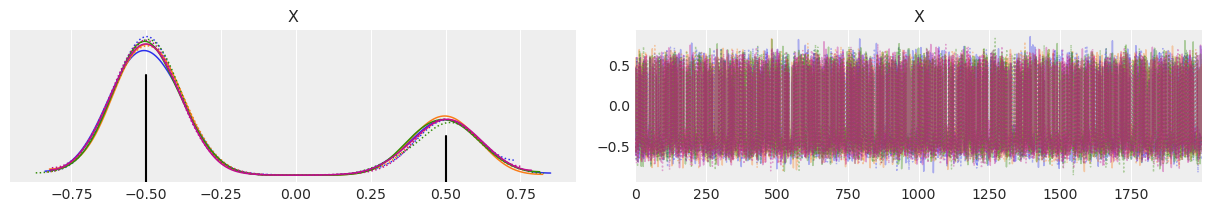

In [118]:
plt.figure()
ax = az.plot_trace(az_smc_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

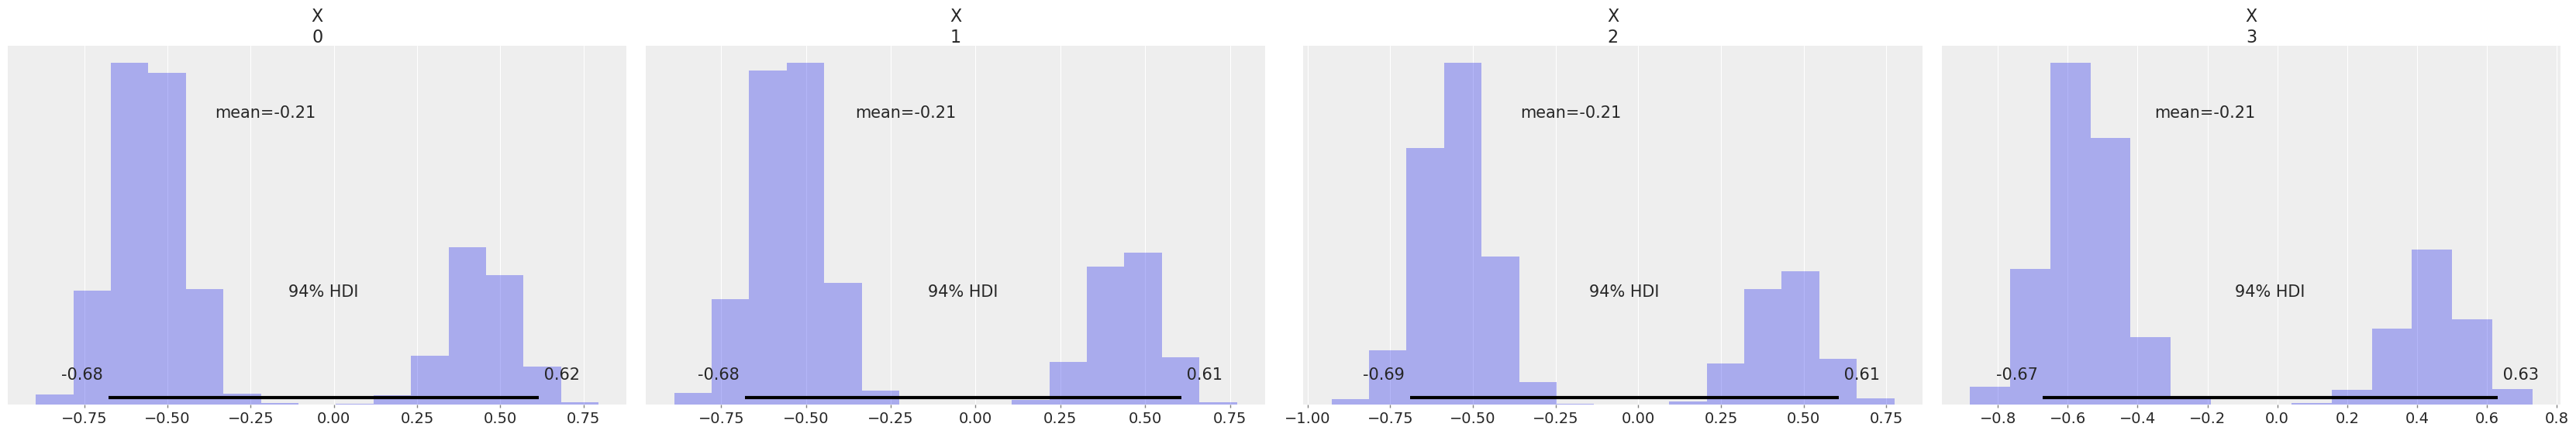

In [119]:
plt.figure()
az.plot_posterior(az_smc_trace, kind='hist')
plt.show()

Below I plot the X[0] posterior obtained from the NFMC and SMC runs. 

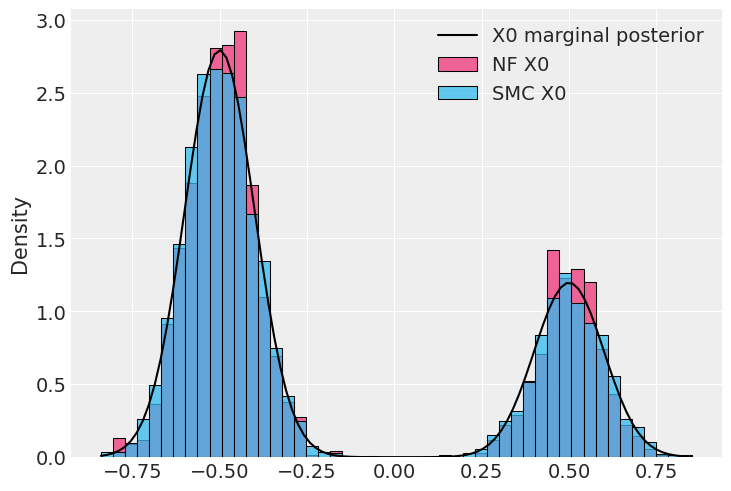

"\nplt.figure()\nsns.distplot(nf_x1, label='NF X1')\nsns.distplot(smc_x1, label='SMC X1')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x2, label='NF X2')\nsns.distplot(smc_x2, label='SMC X2')\nplt.legend(loc='upper right')\nplt.show()\n\nplt.figure()\nsns.distplot(nf_x3, label='NF X3')\nsns.distplot(smc_x3, label='SMC X3')\nplt.legend(loc='upper right')\nplt.show()\n"

In [120]:
def marginal_two_gauss(x, mu1=0.5, mu2=-0.5, sigma=0.1):
    like1 = np.exp(-(x - mu1)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    like2 = np.exp(-(x - mu2)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    return w1 * like1 + w2 * like2

nf_df = az_trace.to_dataframe()
smc_df = az_smc_trace.to_dataframe()

nf_x0 = nf_df[('X[0]', 0)].to_numpy()
nf_x1 = nf_df[('X[1]', 1)].to_numpy()
nf_x2 = nf_df[('X[2]', 2)].to_numpy()
nf_x3 = nf_df[('X[3]', 3)].to_numpy()
smc_x0 = smc_df[('X[0]', 0)].to_numpy()
smc_x1 = smc_df[('X[1]', 1)].to_numpy()
smc_x2 = smc_df[('X[2]', 2)].to_numpy()
smc_x3 = smc_df[('X[3]', 3)].to_numpy()

x_vals = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 100)
y_vals = marginal_two_gauss(x_vals)

bins = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 50)
plt.figure()
sns.histplot(nf_x0, label='NF X0', bins=bins, stat='density', color='#EE3377')
sns.histplot(smc_x0, label='SMC X0', bins=bins, stat='density', color='#33BBEE')
plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

'''
plt.figure()
sns.distplot(nf_x1, label='NF X1')
sns.distplot(smc_x1, label='SMC X1')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x2, label='NF X2')
sns.distplot(smc_x2, label='SMC X2')
plt.legend(loc='upper right')
plt.show()

plt.figure()
sns.distplot(nf_x3, label='NF X3')
sns.distplot(smc_x3, label='SMC X3')
plt.legend(loc='upper right')
plt.show()
'''

In [92]:
rg_model = pm.Model()
x = np.arange(10)
y = 2 * x + 1 + np.random.normal(scale=0.1)

with rg_model:

    a = pm.Normal('a', mu=2, sigma=1)
    b = pm.Normal('b', mu=1, sigma=1)

    like = pm.Normal('like', mu=a*x+b, sigma=0.1, observed=y)
    rg_trace = pm.sample_nf_smc(2000, chains=1, frac_validate=0.2, alpha=(0.6,0.6), NBfirstlayer=True)
    rg_az_trace = az.from_pymc3(rg_trace)

Initializing SMC+SINF sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.009
Stage:   3 Beta: 0.034
Stage:   4 Beta: 0.117
Stage:   5 Beta: 0.403
Stage:   6 Beta: 1.000


365.29053702547066


<Figure size 720x480 with 0 Axes>

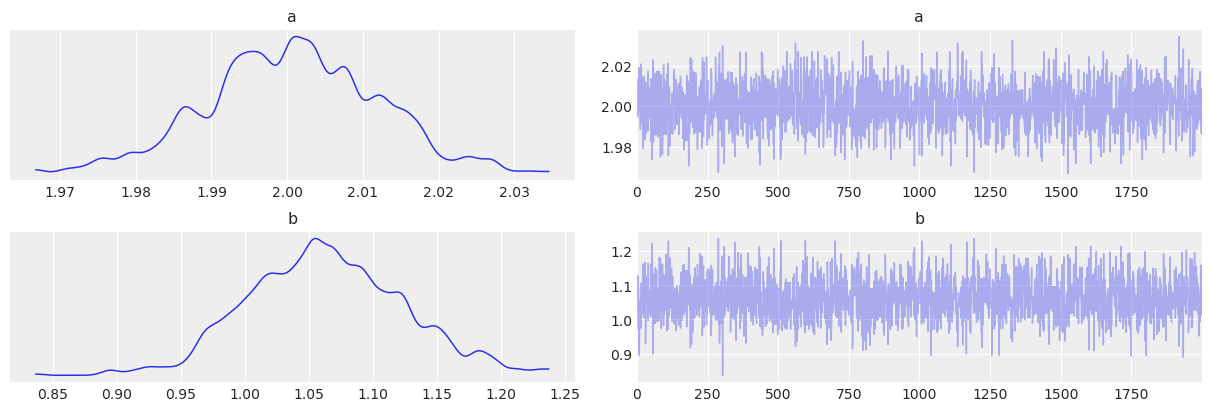

In [93]:
plt.figure()
ax = az.plot_trace(rg_az_trace)
plt.show()

In [22]:
with rg_model:
    nuts_trace = pm.sample(2000)
    nuts_az_trace = az.from_pymc3(nuts_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


<Figure size 720x480 with 0 Axes>

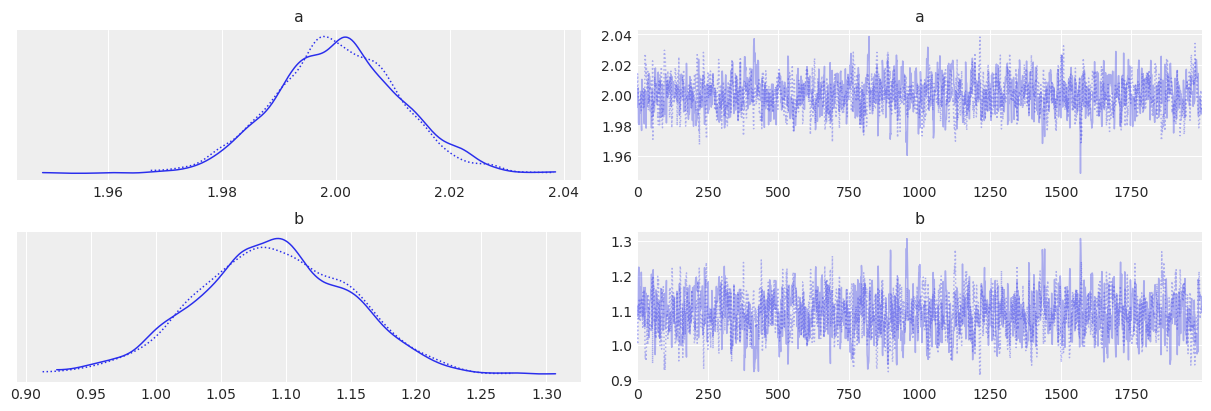

In [23]:
plt.figure()
ax = az.plot_trace(nuts_az_trace)
plt.show()

In [24]:
with rg_model:
    smc_rg_trace = pm.sample_smc(2000)
    az_smc_rg_trace = az.from_pymc3(smc_rg_trace)

Initializing SMC sampler...
Sampling 2 chains in 0 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.008
Stage:   3 Beta: 0.033
Stage:   4 Beta: 0.122
Stage:   5 Beta: 0.431
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.008
Stage:   3 Beta: 0.033
Stage:   4 Beta: 0.118
Stage:   5 Beta: 0.386
Stage:   6 Beta: 1.000


<Figure size 720x480 with 0 Axes>

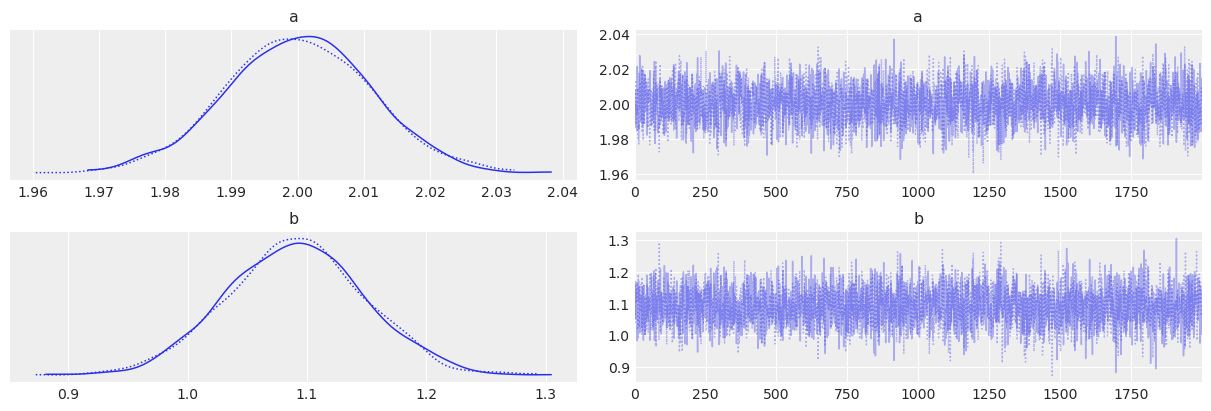

In [25]:
plt.figure()
az.plot_trace(az_smc_rg_trace)
plt.show()

In [26]:
smc_rg_evidence = np.exp(smc_rg_trace.report.log_marginal_likelihood)
print(f'SMC linear regression evidence: {smc_rg_evidence}')

SMC linear regression evidence: [374.48940976 334.27000204]


In [27]:
def z_integrand(a, b):
    p_a = np.exp(-(a - 2)**2 / 2) / np.sqrt(2 * np.pi)
    p_b = np.exp(-(b - 1)**2 / 2) / np.sqrt(2 * np.pi)
    l = np.prod(np.exp(-(y - a * x - b)**2 / (2 * 0.1**2)) / np.sqrt(2 * np.pi * 0.1**2))
    return l * p_a * p_b

from scipy import integrate
result = integrate.dblquad(z_integrand, 0.8, 1.2, 1.96, 2.04)
print(result)

(342.4463477299602, 2.7288241174878015e-05)


Hierarchical Radon Model ....

In [36]:
data = pd.read_csv(pm.get_data("radon.csv"))
data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())

In [37]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data.log_radon)

First, let's sample the posterior using NUTS.

In [39]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)
    hierarchical_az_trace = az.from_pymc3(hierarchical_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 720x480 with 0 Axes>

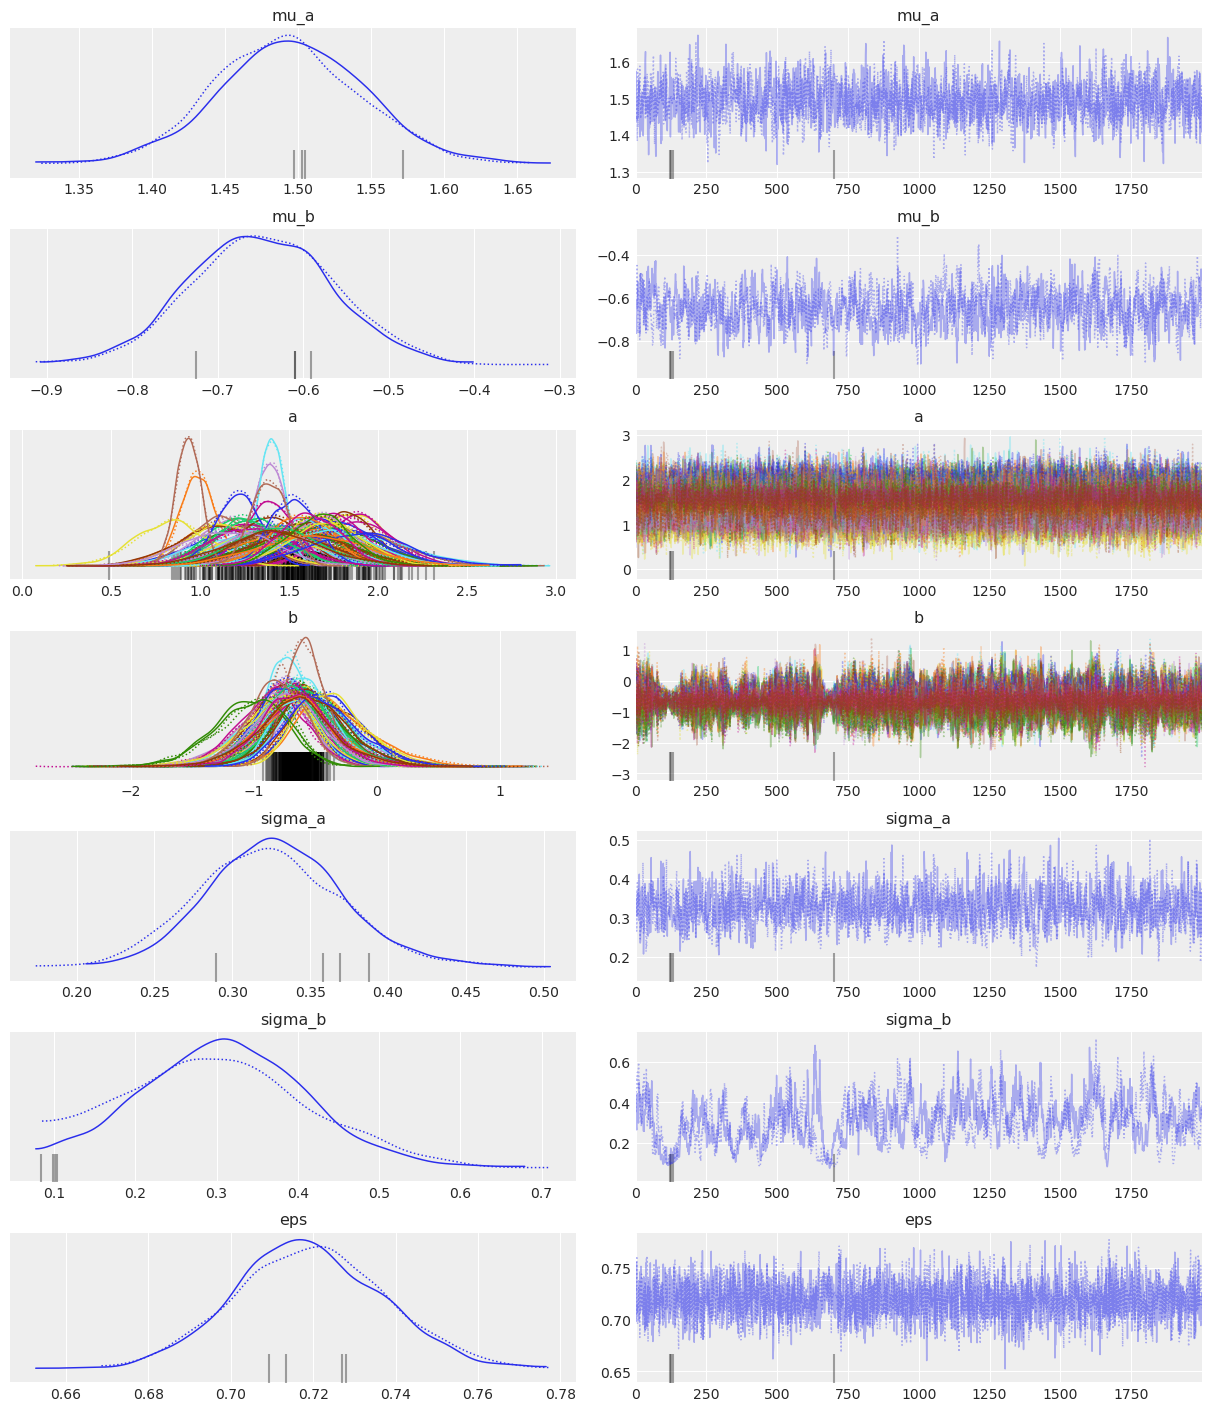

In [43]:
plt.figure()
ax = az.plot_trace(hierarchical_az_trace)
plt.show()

Now let's look at using NFMC.

In [44]:
with hierarchical_model:
    hierarchical_nf_trace = pm.sample_nfmc(500, optim_iter=1000, nf_iter=20, chains=1,
                                           frac_validate=0.2, alpha=(0.5,0.5), parallel=False)
    hierarchical_az_nf_trace = az.from_pymc3(hierarchical_nf_trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


KeyboardInterrupt: 